# Data Visualizations

## Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import os
import PIL
from PIL import Image
import random
import shutil
from typing import Tuple
import webcolors
from webcolors._definitions import _get_hex_to_name_map

In [30]:
# Set paths to data files and directories

CWD = os.getcwd()

# Input paths for data
POKEDEX_PATH = os.path.join(CWD, "data", "pokemon_images", "pokedex.csv")   # Modified .csv file from "Pokemon with Stats and Images"
PKMN_STATS_PATH = os.path.join(CWD, "data", "pokemon_stats.csv")            # .csv file from "Pokemon Pokedex"

# Output paths for created and modified data
PKMN_IMG_COLORS_PATH = os.path.join(CWD, "pokemon_colors.csv")              # Pokemon color data output
PKMN_IMG_DIR = os.path.join(CWD, "data", "pokemon_images", "images")        # Directory containing all Pokemon images

GRAPHICS_DIR = os.path.join(CWD, "graphics")

RNG_SEED = 151

In [4]:
from sklearn.preprocessing import LabelEncoder

# Import in-game statistics dataset
pkmn_stats = pd.read_csv(POKEDEX_PATH, encoding="utf-8", index_col=0)
size_before = pkmn_stats.shape[0]

# Drop ignored rows
pkmn_stats = pkmn_stats[pkmn_stats["Ignore"] == False]
print(f"Dropped {size_before - pkmn_stats.shape[0]} ignored Pokemon. See README.md for details.")

print(f"PKMN stats rows: {pkmn_stats.shape[0]}")
print(f"PKMN stats columns: {list(pkmn_stats.columns)}")

# Set Name to lowercase
pkmn_stats["Name"] = pkmn_stats["Name"].apply(lambda x: x.lower())

# Encode type strings (to ints)
type_label_encoder = LabelEncoder()
pkmn_stats["Type 1"] = type_label_encoder.fit_transform(pkmn_stats["Type 1"])
pkmn_stats["Type 1"] = pkmn_stats["Type 1"].astype(dtype=int)
pkmn_stats["Type 2"] = type_label_encoder.fit_transform(pkmn_stats["Type 2"])
pkmn_stats["Type 2"] = pkmn_stats["Type 2"].astype(dtype=int)

# Change NaN values to "None"
pkmn_stats["Type 2"] = pkmn_stats["Type 2"].apply(lambda x: x if pd.notna(x) else "None")

# Import image colors dataset
pkmn_color_df = pd.read_csv(PKMN_IMG_COLORS_PATH, encoding="utf-8", index_col=0).reset_index(drop=True)
pkmn_color_df = pkmn_color_df.sort_values(by="Number")
print(f"PKMN color rows: {pkmn_color_df.shape[0]}")
print(f"PKMN colors columns: {list(pkmn_color_df.columns)}")

# Add Number and Train columns to pkmn_stats
pkmn_stats = pd.merge(pkmn_stats, pkmn_color_df[["Name", "Number", "Train"]], on=["Name", ], how="inner")

Dropped 232 ignored Pokemon. See README.md for details.
PKMN stats rows: 983
PKMN stats columns: ['Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense', 'SP. Atk.', 'SP. Def', 'Speed', 'Ignore', 'Filename']
PKMN color rows: 959
PKMN colors columns: ['Name', 'Type 1', 'Type 2', 'Filename', 'Number', 'Train', 'black', 'blue', 'pink', 'green', 'purple', 'red', 'white', 'yellow', 'orange']


### Color Analysis Functions

In [5]:
# Edit this dictionary to change the columns used for color analysis
COLOR_DICT = {
    # '#00ffff': 'aqua',
    '#000000': 'black',
    '#0000ff': 'blue',
    '#ff00ff': 'pink',
    '#008000': 'green',
    # '#808080': 'gray',
    # '#00ff00': 'lime',
    # '#800000': 'maroon',
    # '#000080': 'navy',
    # '#808000': 'olive',
    '#800080': 'purple',
    '#ff0000': 'red',
    # '#c0c0c0': 'silver',
    # '#008080': 'teal',
    '#ffffff': 'white',
    '#ffff00': 'yellow',
    '#d29214': 'orange',
}
COLOR_NAMES = list(COLOR_DICT.values())

In [6]:
def closest_color(requested_color: tuple[int, int, int]) -> str:
    """
    Given an RGB tuple, find the closest color name based on Euclidean distance.
    
    Parameters:
        requested_color (Tuple[int, int, int]): The RGB color tuple.
        
    Returns:
        str: The name of the closest color.
    """
    min_distance = float('inf')
    closest_name = None
    for hex, name in COLOR_DICT.items():
        rgb = webcolors.hex_to_rgb(hex)
        distance = sum((comp1 - comp2) ** 2 for comp1, comp2 in zip(requested_color, rgb))
        if distance < min_distance:
            min_distance = distance
            closest_name = name
    
    return closest_name

def image_color_breakdown(image_path: str) -> pd.DataFrame:
    """
    Given the path to a PNG image, compute the percentage breakdown
    of the colors present in the image.
    Transparent pixels (alpha == 0) are ignored.
    
    Parameters:
        image_path (str): The path to the PNG image.
        
    Returns:
        pd.DataFrame: A DataFrame with columns for colors
    """
    # Open the image in RGBA mode to handle transparency.
    img = Image.open(image_path).convert('RGBA')
    # Filter out pixels where the alpha channel is 0 (fully transparent).
    pixels = [pixel for pixel in img.getdata() if pixel[3] != 0]
    
    if not pixels:
        raise ValueError("No non-transparent pixels found in the image.")
    
    total_pixels = len(pixels)
    
    # Count the occurrences of each allowed color.
    color_counts = Counter()
    for pixel in pixels:
        rgb = pixel[:3]
        color_name = color_name = closest_color(rgb)
        color_counts[color_name] += 1
    
    # Prepare the breakdown dictionary with all allowed colors.
    breakdown = {}
    for color in COLOR_NAMES:
        breakdown[color] = 0.0  # default 0%
    
    # Compute the percentage for each color that occurred.
    for color, count in color_counts.items():
        breakdown[color] = (count / total_pixels) * 100
    
    # Create the DataFrame with the columns in the required order.
    df = pd.DataFrame([breakdown], columns=COLOR_NAMES)
    
    return df

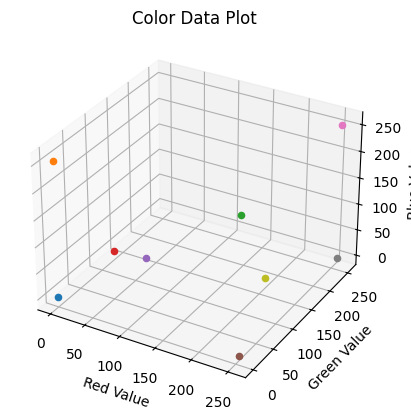

In [78]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import animation

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for color in COLOR_DICT:
    r, g, b = int(f"0x{color[1:3]}", base=16), int(f"0x{color[3:5]}", base=16), int(f"0x{color[5:7]}", base=16)
    color_name = COLOR_DICT[color]
    ax.scatter(r, g, b)

ax.set_title("Color Data Plot")
ax.set_xlabel("Red Value")
ax.set_ylabel("Green Value")
ax.set_zlabel("Blue Value")

plt.savefig(os.path.join(GRAPHICS_DIR, f"color_plot.png"), transparent=True)

plt.show()

## Individual Pokemon Color Analysis

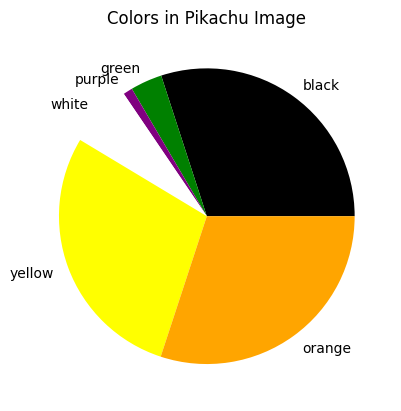

In [34]:
pkmn_name = "Pikachu"

try:
    img_filename = pkmn_stats[pkmn_stats["Name"] == pkmn_name.lower()]["Filename"].iloc[0]
except:
    raise ValueError(f"{pkmn_name.lower()} was not found in Pokemon statistics dataset.")

img_path = os.path.join(PKMN_IMG_DIR, img_filename)

color_df = image_color_breakdown(img_path)

color_df.iloc[0].plot.pie(y="value", colors=color_df.columns, title=f"Colors in {pkmn_name} Image", xlabel="", ylabel="")
plt.savefig(os.path.join(GRAPHICS_DIR, f"{pkmn_name}_colors.png"), transparent=True)

## Distribution of In-Game Statistics

In [7]:
stat_cols = ["HP", "Attack", "Defense", "SP. Atk.", "SP. Def", "Speed"]

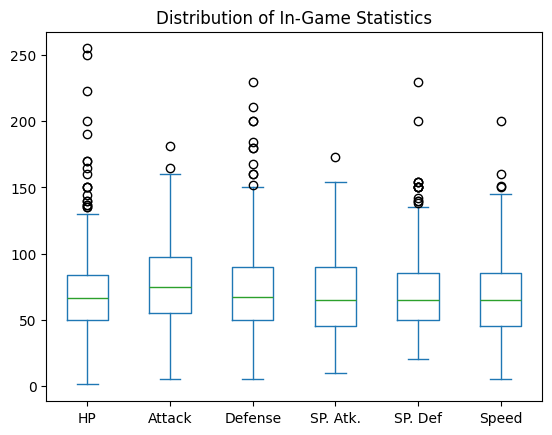

In [8]:
plot = pkmn_stats[stat_cols].plot(kind="box", title="Distribution of In-Game Statistics")